[Deep Learning Summer School 2019](http://2019.dl-lab.eu) in Gdansk, Poland  
**Ordinal Regression Tutorial** by [Sebastian Raschka](https://sebastianraschka.com)  
GitHub Repository: https://github.com/rasbt/DL-Gdansk2019-tutorial  

In [1]:
%load_ext watermark
%watermark -u -d -a 'Sebastian Raschka' -v -p torch,numpy,scipy

Sebastian Raschka 
last updated: 2019-06-28 

CPython 3.6.8
IPython 7.2.0

torch 1.1.0
numpy 1.15.4
scipy 1.1.0


- Runs on CPU or GPU (if available)

# 01 -- Warm-up: Training a Logistic Regression Classifier on MNIST

This tutorial notebook implements a multinomial logistic regression classifier (also known as Softmax Regression classifier) to familiarize ourself with the basic setup with regard to using `DataLoader` training a neural network (here: single layer) in PyTorch.

## Imports

In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

For this tutorial, no GPU is required. However, it is recommended to make sure that this tutorial runs on a GPU, which will be relevant for the more computationally involved examples later.

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cuda:0


## General Settings

In [4]:
##########################
### SETTINGS
##########################


# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.1
NUM_EPOCHS = 20
BATCH_SIZE = 256

# Architecture
NUM_FEATURES = 28*28 # no. of pixels in each image
NUM_CLASSES = 10

## Dataset

In [5]:
##########################
### MNIST DATASET
##########################

train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



# Note transforms.ToTensor() scales input images
# to 0-1 range

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

valid_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=False)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())



train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [6]:
# Check that validation splits are not all from 1 class

for images, labels in valid_loader:  
    pass
print(labels[:10])

tensor([2, 2, 9, 4, 3, 5, 9, 8, 0, 4])


## Model Setup

### Define the model architecture

In [7]:
##########################
### MODEL
##########################

class LogisticRegression(torch.nn.Module):
    """Multinomial Logistic Regression model"""

    def __init__(self, num_features, num_classes):
        super(LogisticRegression, self).__init__()
        
        ### Output layer
        self.linear_out = torch.nn.Linear(NUM_FEATURES, NUM_CLASSES)
        
        # the following two lines are optional
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear_out(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

### Initialize the model

In [8]:
# use random seed for reproducibility (here weight initialization)
torch.manual_seed(RANDOM_SEED)
model = LogisticRegression(num_features=NUM_FEATURES,
                           num_classes=NUM_CLASSES)

# use GPU if available
model = model.to(DEVICE)

# initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## Model Training

Helper function to compute the prediction accuracy:

In [9]:
def compute_accuracy(net, data_loader, device):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

Training loop:

In [10]:
start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)

        optimizer.zero_grad()        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        cost_list.append(cost.item())
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train Acc: {train_acc:.2f}% | Validation Acc: {valid_acc:.2f}%')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/231 | Cost: 2.6417
Epoch: 001/020 | Batch 050/231 | Cost: 0.9123
Epoch: 001/020 | Batch 100/231 | Cost: 0.6201
Epoch: 001/020 | Batch 150/231 | Cost: 0.5684
Epoch: 001/020 | Batch 200/231 | Cost: 0.5137
Epoch: 001/020
Train Acc: 86.94% | Validation Acc: 91.80%
Time elapsed: 1.03 min
Epoch: 002/020 | Batch 000/231 | Cost: 0.5759
Epoch: 002/020 | Batch 050/231 | Cost: 0.4364
Epoch: 002/020 | Batch 100/231 | Cost: 0.4694
Epoch: 002/020 | Batch 150/231 | Cost: 0.4531
Epoch: 002/020 | Batch 200/231 | Cost: 0.3449
Epoch: 002/020
Train Acc: 88.67% | Validation Acc: 92.40%
Time elapsed: 2.06 min
Epoch: 003/020 | Batch 000/231 | Cost: 0.4389
Epoch: 003/020 | Batch 050/231 | Cost: 0.4291
Epoch: 003/020 | Batch 100/231 | Cost: 0.4785
Epoch: 003/020 | Batch 150/231 | Cost: 0.4005
Epoch: 003/020 | Batch 200/231 | Cost: 0.4238
Epoch: 003/020
Train Acc: 89.44% | Validation Acc: 93.00%
Time elapsed: 3.10 min
Epoch: 004/020 | Batch 000/231 | Cost: 0.3113
Epoch: 004/020 | Batc

## Evaluate

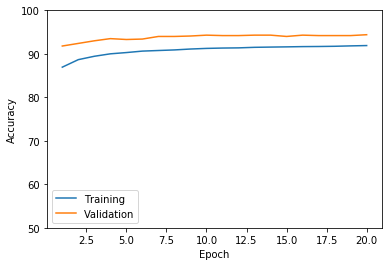

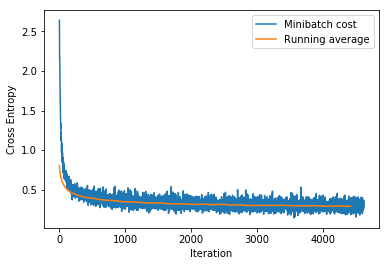

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')
plt.ylim(50, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [12]:
with torch.set_grad_enabled(False):
    acc = compute_accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy: {acc:.2f}%')

Test accuracy: 92.05%
